In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pickle
import os
from tqdm import tqdm

from graspy.plot import heatmap
from graspy.utils import is_symmetric, symmetrize

from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.mgc.mgc import MGC

from simulations import rho_sbm_marg
from utils import sbm_params, triu_no_diag, to_distance_mtx, identity, block_permute, sort_graph, estimate_block_assignment

from rpy2 import robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [15]:
import warnings
warnings.filterwarnings('ignore')

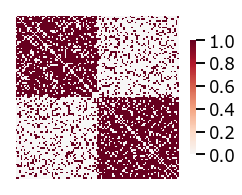

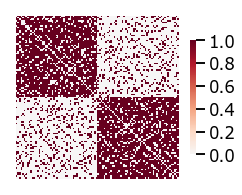

In [16]:
A, B = rho_sbm_marg(rho=0.0, k=2, AL=sbm_params(a=0.8, b=0.2), BL=sbm_params(a=0.8, b=0.2), n=100)
heatmap(A, figsize=(4,3))
heatmap(B, figsize=(4,3))

In [17]:
permuted_vertex = np.random.permutation(np.arange(B.shape[0]))
B_permuted = sort_graph(B, permuted_vertex)

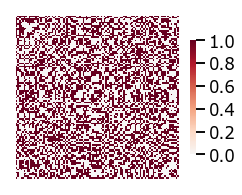

In [18]:
heatmap(B_permuted, figsize=(4,3))

In [19]:
# - Define sgm functions
r_source = ro.r['source']
r_source("../bin/sgm.interface.R")

cmd = """
        fn <- function(g1_matrix, g2_matrix, seeds, reps) {
            sgm.interface(g1_matrix, g2_matrix, seeds, reps)
        }
        """
sgm_fn = ro.r(cmd)

# - Set number of graph matching iterations
reps = 1
ro.r.assign("reps", reps)

# - No seeds
seeds = ro.rinterface.NULL
ro.r.assign("seeds", seeds)

<rpy2.rinterface.NULLType object at 0x124f8a9c8> [RTYPES.NILSXP]

In [20]:
def sgm(A, B):
    nr, nc = A.shape
    A_R = ro.r.matrix(A, nrow=nr, ncol=nc)
    ro.r.assign("A_R", A_R)

    nr, nc = B.shape
    B_R = ro.r.matrix(B, nrow=nr, ncol=nc)
    ro.r.assign("B_R", B_R)

    P = sgm_fn(A, B, seeds, reps)
    P = np.reshape(P, (nr, nr))
    
    B_sorted = sort_graph(B, np.where(P==1)[1])
    
    return A, B_sorted

In [21]:
A, B_sorted = sgm(A, B_permuted)

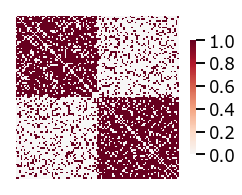

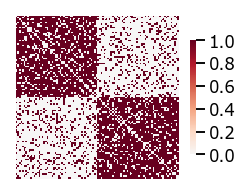

In [22]:
heatmap(A, figsize=(4,3))
heatmap(B_sorted, figsize=(4,3))

In [23]:
mgc = MGC(compute_distance_matrix=identity)

In [24]:
mgc.test_statistic(to_distance_mtx(A), to_distance_mtx(B))

(0.3410746378164093,
 {'local_correlation_matrix': array([[0.34801064, 0.33867973],
         [0.34063526, 0.34107464]]), 'optimal_scale': [2, 2]})

In [25]:
mgc.test_statistic(to_distance_mtx(A), to_distance_mtx(B_sorted))

(0.5455213079861546,
 {'local_correlation_matrix': array([[0.55069236, 0.54302477],
         [0.54344724, 0.54552131]]), 'optimal_scale': [2, 2]})

In [9]:
def rho_sbm_power(indept_test, transform_func, rho, P1, P2, k, n, mc=500, alpha=0.05):
    test_stat_null_array = np.zeros(mc)
    test_stat_alt_array = np.zeros(mc)
    for i in tqdm(range(mc)):
        A, B = rho_sbm_marg(rho, k, P1, P2, n)
        permuted_vertex = np.random.permutation(np.arange(B.shape[0]))
        B_permuted = sort_graph(B, permuted_vertex)
        A, B_matched = sgm(A, B_permuted)      
        
        test_stat_alt, _ = indept_test.test_statistic(
            matrix_X=transform_func(A), matrix_Y=transform_func(B_matched))
        test_stat_alt_array[i] = test_stat_alt

        # generate the null by permutation
        block_assignment = estimate_block_assignment(A, B_matched)
        A_null = block_permute(A, block_assignment)
        B_sorted = sort_graph(B_matched, block_assignment)

        test_stat_null, _ = indept_test.test_statistic(
            matrix_X=transform_func(A_null), matrix_Y=transform_func(B_sorted))
        test_stat_null_array[i] = test_stat_null
    # if pearson, use the absolute value of test statistic then use one-sided
    # rejection region
    if indept_test.get_name() == 'pearson':
        test_stat_null_array = np.absolute(test_stat_null_array)
        test_stat_alt_array = np.absolute(test_stat_alt_array)
    critical_value = np.sort(test_stat_null_array)[math.ceil((1-alpha)*mc)]
    power = np.where(test_stat_alt_array > critical_value)[0].shape[0] / mc
    return power

In [10]:
%%time
n_arr = np.linspace(10, 100, 10, dtype=int)
k=2
nmc = 1000
rho_arr = np.array([0])
P1 = sbm_params(a=0.7, b=0.3)
P2 = sbm_params(a=0.7, b=0.3)
test_names = ['dcorr'] #['pearson', 'dcorr'] , 'mgc']
power_sbm = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

for name in test_names:
    for i, rho in enumerate(rho_arr):
        for j, n in enumerate(n_arr):
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power = rho_sbm_power(test, triu_no_diag, rho=rho, P1=P1, P2=P2, k=k, n=n, mc=nmc)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power = rho_sbm_power(test, to_distance_mtx, rho=rho, P1=P1, P2=P2, k=k, n=n, mc=nmc)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = rho_sbm_power(test, to_distance_mtx, rho=rho, P1=P1, P2=P2, k=k, n=n, mc=nmc)
            power_sbm[name][i, j] = test_power
            print('finish {} for rho={}, n={}'.format(name, rho, n))

  2%|▎         | 25/1000 [00:02<01:30, 10.73it/s]/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)
 17%|█▋        | 169/1000 [00:16<01:17, 10.72it/s]/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)
 34%|███▎      | 336/1000 [00:34<01:11,  9.27it/s]/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)
 40%|████      | 400/1000 [00:41<00:54

finish dcorr for rho=0, n=10


  0%|          | 2/1000 [00:00<01:28, 11.34it/s]

finish dcorr for rho=0, n=20


  0%|          | 1/1000 [00:00<01:52,  8.88it/s]

finish dcorr for rho=0, n=30


  0%|          | 1/1000 [00:00<02:22,  7.03it/s]

finish dcorr for rho=0, n=40


  0%|          | 1/1000 [00:00<02:58,  5.60it/s]

finish dcorr for rho=0, n=50


  0%|          | 0/1000 [00:00<?, ?it/s]

finish dcorr for rho=0, n=60


  0%|          | 0/1000 [00:00<?, ?it/s]

finish dcorr for rho=0, n=70


  0%|          | 0/1000 [00:00<?, ?it/s]

finish dcorr for rho=0, n=80


  0%|          | 0/1000 [00:00<?, ?it/s]

finish dcorr for rho=0, n=90


100%|██████████| 1000/1000 [08:29<00:00,  2.44it/s]

finish dcorr for rho=0, n=100
CPU times: user 49min 25s, sys: 2min 27s, total: 51min 53s
Wall time: 38min 5s


In [11]:
power_sbm

{'pearson': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 'dcorr': array([[0.108, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
         1.   ]]),
 'mgc': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])}